In [1]:
import sys; sys.path.append("../../automl/")

In [2]:
from pathlib import Path
import yaml
import joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from src.automl.model.lama import TabularLama
from src.automl.loggers import configure_root_logger
from src.automl.constants import create_ml_data_dir
from src.automl.model.metrics import RocAuc

In [3]:
create_ml_data_dir()
configure_root_logger()

## Constants

In [4]:
RANDOM_SEED = 77
DATA_PATH = Path("../../data/")
CONFIG_PATH = Path("../../configs/config.yaml")
N_JOBS = 16

In [5]:
with CONFIG_PATH.open() as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)

## Data

In [6]:
df_train = pd.read_parquet(DATA_PATH / "train_preproc.parquet")
df_train, df_test = df_train.sort_values(by="id").iloc[:300_000], df_train.sort_values(by="id").iloc[300_000:]

In [7]:
df_train["target"].value_counts()

0    282256
1     17744
Name: target, dtype: int64

In [8]:
# undersample the 0 class
df_train = pd.concat([df_train.loc[df_train.target == 1], df_train.loc[df_train.target == 0].sample(200_000, random_state=RANDOM_SEED)], ignore_index=True)

In [9]:
ohe_cols = df_train.columns[df_train.columns.str.startswith("OneHotEncoder")].values.tolist()
oe_cols = df_train.columns[df_train.columns.str.startswith("OrdinalEncoder")].values.tolist()
te_cols = df_train.columns[df_train.columns.str.startswith("MeanTargetEncoder")].values.tolist()

In [10]:
# take target encoded columns
X_train, y_train = df_train[cfg["selected_features"] + te_cols + ohe_cols], df_train["target"]
X_test, y_test = df_test[cfg["selected_features"] + te_cols + ohe_cols], df_test["target"]

In [109]:
# take all columns
X_train, y_train = df_train.drop(columns=["target", "id", "smpl"]), df_train["target"]
X_test, y_test = df_test.drop(columns=["target", "id", "smpl"]), df_test["target"]

In [73]:
# take ordinal encoded columns
X_train, y_train = df_train[cfg["selected_features"] + oe_cols + ohe_cols], df_train["target"]
X_test, y_test = df_test[cfg["selected_features"] + oe_cols + ohe_cols], df_test["target"]

In [13]:
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

0    0.91851
1    0.08149
Name: target, dtype: float64

0    0.941322
1    0.058678
Name: target, dtype: float64

In [11]:
categorical_features = ohe_cols# + oe_cols

## Model

In [12]:
metric = RocAuc()

In [14]:
model = TabularLama(n_jobs=16)
model.tune(X_train, y_train, metric, timeout=60 * 30, categorical_features=categorical_features)
oof = model.fit(X_train, y_train, categorical_features=categorical_features)
y_pred = model.predict(X_test)

print(metric(y_train, oof))
print(metric(y_test, y_pred))

[2024-11-06 10:41:47,974] - [   START    ] - Fitting TabularLama
[10:41:48] Stdout logging level is INFO.
[10:41:48] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[10:41:48] Task: reg

[10:41:48] Start automl preset with listed constraints:
[10:41:48] - time: 3600.00 seconds
[10:41:48] - CPU: 16 cores
[10:41:48] - memory: 16 GB

[10:41:48] Train data shape: (217744, 68)

[10:41:58] Layer 1 train process start. Time left 3589.57 secs
[10:42:04] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:42:17] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7819380924537872
[10:42:17] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:42:17] Time left 3570.38 secs

[10:42:24] Selector_LightGBM fitting and predicting completed
[10:42:29] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:42:53] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8016182053088369
[10:42:53] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicti

In [15]:
MODEL_NAME = "lama_8029"
MODEL_DIR = Path(f"../../data/models/{MODEL_NAME}")
MODEL_DIR.mkdir(exist_ok=True)

In [18]:
res = pd.DataFrame()
res[MODEL_NAME] = oof
res.to_csv(MODEL_DIR / "oof.csv", index=False)
joblib.dump(model, MODEL_DIR / f"{MODEL_NAME}.joblib")

with (MODEL_DIR / "params.yaml").open("w") as f:
    yaml.dump(model.params, f)

with (MODEL_DIR / "score.txt").open("w") as f:
    print("OOF:", metric(y_train, oof), file=f)
    print("Test:", metric(y_test, y_pred), file=f)

In [32]:
model.model.get_feature_scores().iloc[:60]

,Feature,Importance
0,numeric__feature_16,12071.364147
1,numeric__feature_168,1188.525494
2,numeric__feature_11,1188.361985
3,numeric__feature_100,1052.872579
4,numeric__feature_8,807.179672
5,numeric__feature_142,800.872718
6,numeric__feature_25,776.447171
7,numeric__feature_26,645.328227
8,numeric__feature_46,637.556413
9,numeric__feature_78,553.738458


<Axes: xlabel='Feature', ylabel='Importance'>

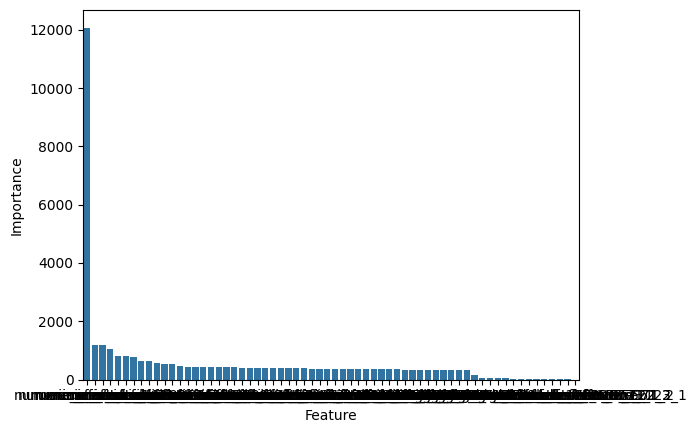

In [23]:
import seaborn as sns
sns.barplot(model.model.get_feature_scores(), x="Feature", y="Importance")

In [15]:
test = pd.read_parquet(DATA_PATH / "test_preproc.parquet")
test["target"] = model.predict(test[cfg["selected_features"] + te_cols + ohe_cols])[:, 1]
test[['id', 'target']].to_csv('lgb_full_dataset.csv', index=False)

In [25]:
pred_1 = pd.read_csv("lama_utilized.csv")
pred_2 = pd.read_csv("lgmb_oe_ohe_cols_0805.csv")
pred_3 = pd.read_csv("catboost_ts.csv")

In [26]:
pred_1["target"] = 0.6 * pred_1["target"] + 0.2 * pred_2["target"] + 0.2 * pred_3["target"]

In [29]:
pred_1.to_csv("blend.csv", index=False)

In [166]:
MODEL_DIR.open?

Signature:
MODEL_DIR.open(
    mode='r',
    buffering=-1,
    encoding=None,
    errors=None,
    newline=None,
)
Docstring:
Open the file pointed by this path and return a file object, as
the built-in open() function does.
File:      /usr/lib/python3.10/pathlib.py
Type:      method